# Group 27: Deep Learning Assignment

## Imports & Helpers

In [9]:
import os, time, random, csv
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from collections import Counter



## Data preparation

In [ ]:
# Directories
TRAIN_DIR = "Train"
TEST_DIR  = "Test"
# AccentAudioDataset 
class AccentAudioDataset(Dataset):
    def __init__(self, data_dir):
        self.paths = sorted(glob(os.path.join(data_dir,'*.wav')))
        if not self.paths: raise RuntimeError(f"No .wav in {data_dir}")
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        w, sr = torchaudio.load(p)
        if sr!=16000: w = torchaudio.functional.resample(w, sr, 16000)
        w = (w - w.mean())/(w.std()+1e-9)
        fname = os.path.basename(p)
        accent = int(fname[0]) - 1
        gender = 0 if fname[1].lower()=='m' else 1
        return w.squeeze(0), accent, gender

def collate_fn(batch):
    waves, accents, genders = zip(*batch)
    lengths = torch.tensor([w.size(0) for w in waves])
    padded = pad_sequence(waves, batch_first=True)
    return padded, lengths, torch.tensor(accents), torch.tensor(genders)

# Split of data with 20% for validation
full_ds = AccentAudioDataset(TRAIN_DIR)
n_tot = len(full_ds)
n_val = int(0.2*n_tot); n_train = n_tot - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=False, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=False, collate_fn=collate_fn)

print("Train/Val:", n_train, n_val)

Train/Val: 2533 633


## Data exploration

Total samples: 3166
Accent counts: Counter({4: 754, 1: 740, 2: 626, 3: 564, 5: 482})
Gender counts: Counter({'f': 1639, 'm': 1527})
Duration (s) → min: 1.67, max: 12.97, mean: 5.26, median: 5.04


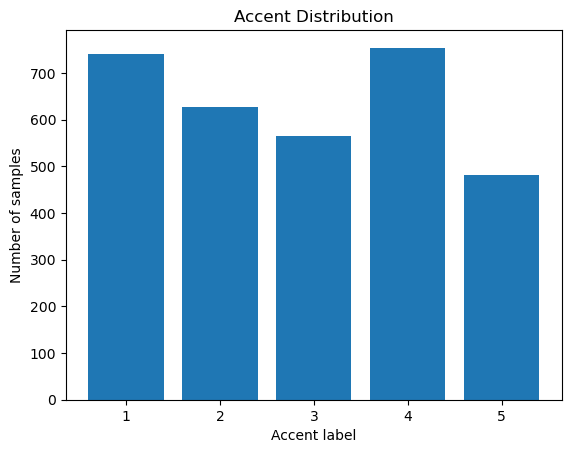

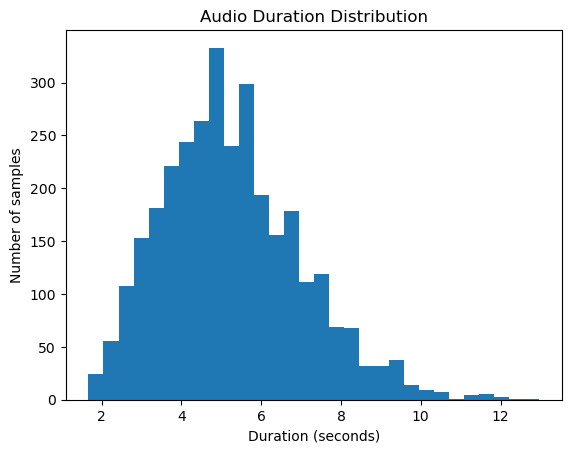

In [ ]:
# Getting *.wav durations and labels
DATA_DIR = 'Train'
filepaths = sorted(glob(os.path.join(DATA_DIR, '*.wav')))
accents, genders, durations = [], [], []

for path in filepaths:
    fname = os.path.basename(path)
    accents.append(int(fname[0]))          # Accents 1–5
    genders.append(fname[1].lower())       # Male or female
    info = torchaudio.info(path)
    durations.append(info.num_frames / info.sample_rate)

durations = np.array(durations)

# Summary statistics
print(f"Total samples: {len(filepaths)}")
print("Accent counts:", Counter(accents))
print("Gender counts:", Counter(genders))
print(
    f"Duration (s) → min: {durations.min():.2f}, "
    f"max: {durations.max():.2f}, mean: {durations.mean():.2f}, "
    f"median: {np.median(durations):.2f}"
)

#Plots 
plt.figure()
counts = Counter(accents)
keys = sorted(counts.keys())
plt.bar(keys, [counts[k] for k in keys])
plt.xlabel("Accent label")
plt.ylabel("Number of samples")
plt.title("Accent Distribution")
plt.show()

# Histogram of durations
plt.figure()
plt.hist(durations, bins=30)
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of samples")
plt.title("Audio Duration Distribution")
plt.show()

## Task 1.2a: RawCNN1D Model 

In [14]:
class RawCNNv2(nn.Module):
    def __init__(self,num_classes=5,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1,32,7,stride=2,padding=3),
            nn.BatchNorm1d(32), nn.ReLU(True), nn.MaxPool1d(2),
            nn.Conv1d(32,64,5,stride=2,padding=2),
            nn.BatchNorm1d(64), nn.ReLU(True), nn.MaxPool1d(2),
            nn.Conv1d(64,128,3,stride=2,padding=1),
            nn.BatchNorm1d(128), nn.ReLU(True), nn.MaxPool1d(2),
            nn.AdaptiveAvgPool1d(1), nn.Flatten(),
            nn.Dropout(dropout), nn.Linear(128,num_classes)
        )
    def forward(self,x):
        return self.net(x.unsqueeze(1))

### Augmentations: + Noise and Random-Shift Augmentation 

In [ ]:
#In order to add robustness Noise is added and shifts on the wave of the data too.  
class AddNoise:
    def __call__(self,w):
        rms=w.pow(2).mean().sqrt(); return w+torch.randn_like(w)*rms*0.05
class RandomShift: 
    def __call__(self,w):
        return torch.roll(w, shifts=random.randint(-1000,1000))
class WaveAugDataset(AccentAudioDataset): # Inherits from AccentAudioDataset, which standardizes the raw wav
    # This makes sure the augmented waveform is re-centered and rescaled so the network sees inputs with a consistent scale, 
    # regardless of how the augmentations distorted them
    def __init__(self,d,augs): super().__init__(d); self.augs=augs
    def __getitem__(self,i):
        w,a,g=super().__getitem__(i)
        for aug in self.augs: w=aug(w)
        w=(w-w.mean())/(w.std()+1e-9)
        return w,a,g

aug_loader = DataLoader(WaveAugDataset(TRAIN_DIR,[AddNoise(),RandomShift()]),
    batch_size=32,shuffle=True,num_workers=0,pin_memory=False,collate_fn=collate_fn)
print("Aug loader:", len(aug_loader.dataset))

Aug loader: 3166


### Training of RawCNN

Definitions of functions that are used in training of the RawCNN

In [17]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for inputs, lengths, accents, genders in loader:
        inputs = inputs.to(device)
        accents = accents.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, accents)
        loss.backward()
        optimizer.step()
        
        b = inputs.size(0)
        total_loss += loss.item() * b
        preds = outputs.argmax(dim=1)
        correct += (preds == accents).sum().item()
        total += b
    
    return total_loss/total, correct/total, time.time() - start_time

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, lengths, accents, genders in loader:
            inputs = inputs.to(device)
            accents = accents.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, accents)
            
            b = inputs.size(0)
            total_loss += loss.item() * b
            preds = outputs.argmax(dim=1)
            correct += (preds == accents).sum().item()
            total += b
    
    return total_loss/total, correct/total

In [18]:
#Using MPS, as training was done on Mac Sillicon, swap out 'cpu' for 'cuda' if you have a NVIDIA GPU.
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu') 
model_raw = RawCNNv2().to(device)
opt_raw = torch.optim.Adam(model_raw.parameters(), lr=1e-3, weight_decay=1e-4)
sched_raw = torch.optim.lr_scheduler.OneCycleLR(opt_raw, max_lr=1e-3, total_steps=50, pct_start=0.3)

best_acc, best_ep = 0,0
# Training for 50 epochs -> yielded good results with acceptable training time
for ep in range(1,51):
    tr_loss,tr_acc,_=train_one_epoch(model_raw,aug_loader,opt_raw,device)
    vl_loss,vl_acc  =evaluate(model_raw,val_loader,device)
    sched_raw.step()
    if vl_acc>best_acc:
        best_acc,best_ep=vl_acc,ep; torch.save(model_raw.state_dict(),'best_rawcnn.pt')
    print(f"Epoch {ep:02d} | tr_acc {tr_acc:.3f} | val_acc {vl_acc:.3f}")
print("Best RawCNN2:",best_acc,"at epoch",best_ep)

Epoch 01 | tr_acc 0.189 | val_acc 0.209
Epoch 02 | tr_acc 0.275 | val_acc 0.316
Epoch 03 | tr_acc 0.325 | val_acc 0.311
Epoch 04 | tr_acc 0.368 | val_acc 0.368
Epoch 05 | tr_acc 0.410 | val_acc 0.393
Epoch 06 | tr_acc 0.437 | val_acc 0.427
Epoch 07 | tr_acc 0.446 | val_acc 0.400
Epoch 08 | tr_acc 0.462 | val_acc 0.276
Epoch 09 | tr_acc 0.474 | val_acc 0.469
Epoch 10 | tr_acc 0.485 | val_acc 0.458
Epoch 11 | tr_acc 0.491 | val_acc 0.494
Epoch 12 | tr_acc 0.506 | val_acc 0.452
Epoch 13 | tr_acc 0.504 | val_acc 0.338
Epoch 14 | tr_acc 0.521 | val_acc 0.321
Epoch 15 | tr_acc 0.528 | val_acc 0.431
Epoch 16 | tr_acc 0.545 | val_acc 0.415
Epoch 17 | tr_acc 0.545 | val_acc 0.526
Epoch 18 | tr_acc 0.548 | val_acc 0.588
Epoch 19 | tr_acc 0.552 | val_acc 0.412
Epoch 20 | tr_acc 0.563 | val_acc 0.551
Epoch 21 | tr_acc 0.564 | val_acc 0.529
Epoch 22 | tr_acc 0.567 | val_acc 0.583
Epoch 23 | tr_acc 0.570 | val_acc 0.539
Epoch 24 | tr_acc 0.572 | val_acc 0.651
Epoch 25 | tr_acc 0.583 | val_acc 0.436


### Evaluating the RawCNN model

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_detailed(model, loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, lengths, accents, genders in loader:
            inputs = inputs.to(device)
            accents = accents.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(accents.cpu().numpy())

    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)

# Classification Report
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names if class_names else [f"Accent {i+1}" for i in range(len(set(y_true)))],
        digits=2
    )

# Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    print("\nClassification Report (Accents):")
    print(report)
    print("Confusion Matrix:")
    print(cm)


model_raw.load_state_dict(torch.load("best_rawcnn.pt", map_location=device))
evaluate_detailed(model_raw, val_loader, device)




Classification Report (Accents):
              precision    recall  f1-score   support

    Accent 1       0.81      0.98      0.89       146
    Accent 2       0.66      0.64      0.65       126
    Accent 3       0.77      0.61      0.68       113
    Accent 4       0.62      0.68      0.65       156
    Accent 5       0.63      0.50      0.56        92

    accuracy                           0.70       633
   macro avg       0.70      0.68      0.68       633
weighted avg       0.70      0.70      0.70       633

Confusion Matrix:
[[143   1   0   0   2]
 [  9  81   4  25   7]
 [  7   7  69  24   6]
 [  6  20  12 106  12]
 [ 12  14   5  15  46]]



Classification Report (Accents):
              precision    recall  f1-score   support

    Accent 1       0.81      0.98      0.89       146
    Accent 2       0.66      0.64      0.65       126
    Accent 3       0.77      0.61      0.68       113
    Accent 4       0.62      0.68      0.65       156
    Accent 5       0.63      0.50      0.56        92

    accuracy                           0.70       633
   macro avg       0.70      0.68      0.68       633
weighted avg       0.70      0.70      0.70       633

Confusion Matrix:
[[143   1   0   0   2]
 [  9  81   4  25   7]
 [  7   7  69  24   6]
 [  6  20  12 106  12]
 [ 12  14   5  15  46]]


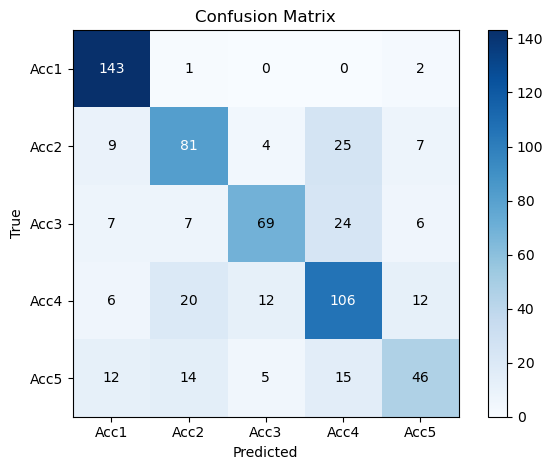

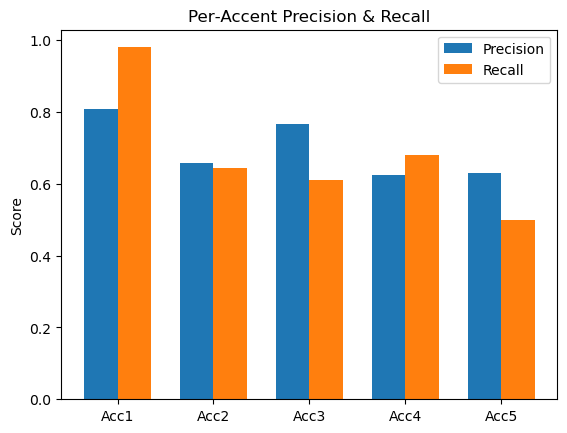

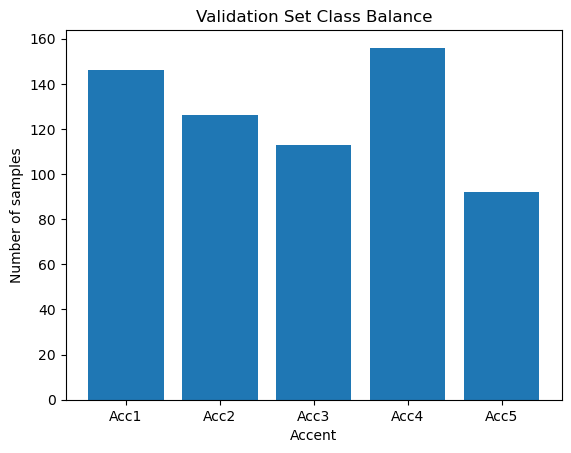

In [21]:
# Importing some libraries again, to make sure the plots work 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

#Modified evaluate_detailed to return y_true, y_pred for the plots 
def evaluate_and_return(model, loader, device, class_names=None):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, lengths, accents, genders in loader:
            inputs = inputs.to(device)
            accents = accents.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(accents.cpu().numpy())

    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)

    # Printing the reports 
    print("\nClassification Report (Accents):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names or [f"Accent {i+1}" for i in range(5)],
        digits=2,
        zero_division=0
    ))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4]))

    return y_true, y_pred


y_true, y_pred = evaluate_and_return(model_raw, val_loader, device)

# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(5), yticks=np.arange(5),
    xticklabels=[f"Acc{i}" for i in range(1,6)],
    yticklabels=[f"Acc{i}" for i in range(1,6)],
    xlabel="Predicted", ylabel="True", title="Confusion Matrix"
)
thresh = cm.max() / 2
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# Accent-specific precision & recall bar chart
prec, rec, _, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0,1,2,3,4], zero_division=0
)
labels = [f"Acc{i}" for i in range(1,6)]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, prec, width, label="Precision")
ax.bar(x + width/2, rec,  width, label="Recall")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Score")
ax.set_title("Per‐Accent Precision & Recall")
ax.legend()
plt.show()

# Class‐balance bar chart (validation support)
counts = np.bincount(y_true, minlength=5)
plt.figure()
plt.bar(labels, counts)
plt.xlabel("Accent")
plt.ylabel("Number of samples")
plt.title("Validation Set Class Balance")
plt.show()

## 1.2b: Log-Mel Spectogram Data Loader (SpectogramDataset & spec_collate)

In [22]:
# SpectrogramDataset & collate 
class SpectrogramDataset(Dataset):
    def __init__(self,d,tf): self.paths=sorted(glob(os.path.join(d,'*.wav'))); self.tf=tf
    def __len__(self): return len(self.paths)
    def __getitem__(self,i):
        p=self.paths[i]; w,sr=torchaudio.load(p)
        if sr!=16000: w=torchaudio.functional.resample(w,sr,16000)
        w=(w-w.mean())/(w.std()+1e-9)
        spec=self.tf(w); spec=torch.log(spec+1e-9)
        fname=os.path.basename(p); a=int(fname[0])-1; g=0 if fname[1].lower()=='m' else 1
        return spec,a,g

def spec_collate(batch):
    specs,accs,gens=zip(*batch)
    T_max=max(s.size(2) for s in specs)
    padded=[torch.nn.functional.pad(s,(0,T_max-s.size(2))) for s in specs]
    return torch.stack(padded,0), torch.tensor(accs), torch.tensor(gens)



mel_tf = T.MelSpectrogram(sample_rate=16000, n_mels=64)
spec_full  = SpectrogramDataset(TRAIN_DIR, mel_tf)
spec_train = Subset(spec_full, train_ds.indices)
spec_val   = Subset(spec_full, val_ds.indices)

spec_train_loader = DataLoader(
    spec_train,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    collate_fn=spec_collate
)
spec_val_loader = DataLoader(
    spec_val,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=spec_collate
)

print("Spec loaders:", len(spec_train), len(spec_val))

Spec loaders: 2533 633


### Data Augmentation (SpecAugment Data Loader (SpecAugDataset + Frequency/Time Masking))

In [25]:
#Define SpecAugDataset

from torchaudio.transforms import FrequencyMasking, TimeMasking

# Create the two masks once
freq_mask = FrequencyMasking(freq_mask_param=15)
time_mask = TimeMasking(time_mask_param=35)

# Inherit from existing SpectrogramDataset
class SpecAugDataset(SpectrogramDataset):
    """
    Same as SpectrogramDataset but applies SpecAugment (freq & time masking).
    """
    def __init__(self, data_dir, transform):
        super().__init__(data_dir, transform)
        self.freq_mask = freq_mask
        self.time_mask = time_mask

    def __getitem__(self, idx):
        spec, accent, gender = super().__getitem__(idx)
        # apply masking in-place
        spec = self.freq_mask(spec)
        spec = self.time_mask(spec)
        return spec, accent, gender



### SpectrogramCNN Model Definition

In [26]:
# Define SpectrogramCNN

import torch
import torch.nn as nn

class SpectrogramCNN(nn.Module):
    """
    2D CNN for log‐Mel spectrograms (5 accents).
    """
    def __init__(self, num_classes=5, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [B, 1, F, T]
        return self.net(x)



### Setup: Spectrogram + SpecAugment Pipeline (Weighted Loss, Oversampling, Loaders, Model & Scheduler)

In [27]:
# Redefine Missing Variables & Functions for SpectrogramCNN Pipeline (Fixed)

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio.transforms import FrequencyMasking, TimeMasking
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import numpy as np

# Device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Build augmented‐spectrogram training subset
spec_aug_full  = SpecAugDataset(TRAIN_DIR, mel_tf)
spec_aug_train = Subset(spec_aug_full, train_ds.indices)

#Compute per‐class counts & inverse‐frequency weights
train_labels   = [label for _, label, _ in spec_aug_train]
train_counts   = np.bincount(train_labels, minlength=5)
class_weights  = 1.0 / train_counts

# Normalize and move to device
weights = torch.tensor(class_weights, dtype=torch.float, device=device)
weights = weights / weights.sum() * len(weights)

#Create weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=weights)

#Spec‐specific train/eval helpers
def train_one_epoch_spec(model, loader, optimizer, device):
    model.train()
    total_loss = correct = total = 0
    start = time.time()
    for specs, accents, genders in loader:
        specs, accents = specs.to(device), accents.to(device)
        optimizer.zero_grad()
        logits = model(specs)
        loss   = criterion(logits, accents)   # uses weighted loss
        loss.backward()
        optimizer.step()
        b = specs.size(0)
        total_loss += loss.item() * b
        correct    += (logits.argmax(1) == accents).sum().item()
        total      += b
    return total_loss/total, correct/total, time.time() - start

def evaluate_spec(model, loader, device):
    model.eval()
    total_loss = correct = total = 0
    with torch.no_grad():
        for specs, accents, genders in loader:
            specs, accents = specs.to(device), accents.to(device)
            logits = model(specs)
            loss   = F.cross_entropy(logits, accents)
            b = specs.size(0)
            total_loss += loss.item() * b
            correct    += (logits.argmax(1) == accents).sum().item()
            total      += b
    return total_loss/total, correct/total

#Build oversampled SpecAug DataLoader
example_weights = [class_weights[l] for l in train_labels]
sampler = WeightedRandomSampler(
    weights     = example_weights,
    num_samples = len(example_weights),
    replacement = True
)
spec_aug_loader = DataLoader(
    spec_aug_train,
    batch_size   = 32,
    sampler      = sampler,        # no shuffle
    num_workers  = 0,
    pin_memory   = False,
    collate_fn   = spec_collate
)

#Validation loader
spec_val_full   = SpectrogramDataset(TRAIN_DIR, mel_tf)
spec_val_subset = Subset(spec_val_full, val_ds.indices)
spec_val_loader = DataLoader(
    spec_val_subset,
    batch_size   = 32,
    shuffle      = False,
    num_workers  = 0,
    pin_memory   = False,
    collate_fn   = spec_collate
)

#Model + Optimizer + Scheduler setup
model_spec     = SpectrogramCNN(num_classes=5, dropout=0.1).to(device)
optimizer_spec = optim.Adam(model_spec.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler_spec = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_spec, mode='min', factor=0.5, patience=1
)



In [29]:
import numpy as np
import torch.nn as nn

#Extracting all accent labels from  train_ds
train_labels = [label for _, label, _ in train_ds]  

# Computing counts per class
train_counts = np.bincount(train_labels, minlength=5)
print("Train‐split counts (support) per accent:", train_counts)

# Building inverse‐frequency weights (use float32 on MPS)
weights = torch.tensor(1.0 / train_counts, dtype=torch.float32, device=device)
# Normalizing so average weight ≈ 1
weights = weights / weights.sum() * len(weights)
print("Computed class weights:", weights)

# Creating weighted loss
criterion = nn.CrossEntropyLoss(weight=weights)


Train‐split counts (support) per accent: [594 500 451 598 390]
Computed class weights: tensor([0.8304, 0.9865, 1.0936, 0.8248, 1.2647], device='mps:0')


In [ ]:
# Train+Checkpoint → Load Best → Eval → Submission

import os, csv
import torch
import torchaudio
from glob import glob
from torch.utils.data import Dataset, DataLoader, Subset
from torchaudio.transforms import FrequencyMasking, TimeMasking

best_val_acc = 0.0
ckpt_path    = "best_speccnn.pt"

for epoch in range(1, 51):
    tr_loss, tr_acc, _ = train_one_epoch_spec(
        model_spec, spec_aug_loader, optimizer_spec, device
    )
    vl_loss, vl_acc    = evaluate_spec(
        model_spec, spec_val_loader, device
    )
    scheduler_spec.step(vl_loss)

    # Checkpointing on improvement
    if vl_acc > best_val_acc + 1e-4:
        best_val_acc = vl_acc
        torch.save(model_spec.state_dict(), ckpt_path)

    print(f"[SpecAug] Epoch {epoch:02d} | "
          f"Train Acc: {tr_acc:.3f} | Val Acc: {vl_acc:.3f}")

print(f" Best val_acc = {best_val_acc:.3f}, saved to {ckpt_path}")

# Loading best weights & final validation
model_spec.load_state_dict(torch.load(ckpt_path, map_location=device))
model_spec.eval()

final_loss, final_acc = evaluate_spec(model_spec, spec_val_loader, device)
print(f"\nFinal Validation → Loss: {final_loss:.4f}, Acc: {final_acc:.3f}")


class SpecTestDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.paths = sorted(glob(os.path.join(data_dir, "*.wav")))
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        path = self.paths[idx]
        wav, sr = torchaudio.load(path)
        if sr != 16000:
            wav = torchaudio.functional.resample(wav, sr, 16000)
        wav = (wav - wav.mean())/(wav.std()+1e-9)
        spec = self.transform(wav)
        spec = torch.log(spec + 1e-9)
        return spec, os.path.basename(path)

def test_collate(batch):
    specs, fnames = zip(*batch)
    T_max = max(s.size(2) for s in specs)
    padded = [torch.nn.functional.pad(s, (0, T_max-s.size(2))) for s in specs]
    return torch.stack(padded, 0), list(fnames)


test_ds     = SpecTestDataset(TEST_DIR, mel_tf)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False,
                         num_workers=0, pin_memory=False,
                         collate_fn=test_collate)

filenames, accents = [], []
with torch.no_grad():
    for specs, fnames in test_loader:
        specs = specs.to(device)
        preds = model_spec(specs).argmax(dim=1).cpu().tolist()
        filenames.extend(fnames)
        accents.extend([p+1 for p in preds])

# write CSV
with open("submission.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "accent"])
    writer.writerows(zip(filenames, accents))

print(f"submission.csv created with {len(accents)} rows")

[SpecAug] Epoch 01 | Train Acc: 0.259 | Val Acc: 0.240
[SpecAug] Epoch 02 | Train Acc: 0.304 | Val Acc: 0.365
[SpecAug] Epoch 03 | Train Acc: 0.364 | Val Acc: 0.368
[SpecAug] Epoch 04 | Train Acc: 0.362 | Val Acc: 0.343
[SpecAug] Epoch 05 | Train Acc: 0.370 | Val Acc: 0.333
[SpecAug] Epoch 06 | Train Acc: 0.415 | Val Acc: 0.275
[SpecAug] Epoch 07 | Train Acc: 0.460 | Val Acc: 0.324
[SpecAug] Epoch 08 | Train Acc: 0.446 | Val Acc: 0.510
[SpecAug] Epoch 09 | Train Acc: 0.493 | Val Acc: 0.414
[SpecAug] Epoch 10 | Train Acc: 0.492 | Val Acc: 0.501
[SpecAug] Epoch 11 | Train Acc: 0.503 | Val Acc: 0.613
[SpecAug] Epoch 12 | Train Acc: 0.525 | Val Acc: 0.562
[SpecAug] Epoch 13 | Train Acc: 0.561 | Val Acc: 0.558
[SpecAug] Epoch 14 | Train Acc: 0.555 | Val Acc: 0.455
[SpecAug] Epoch 15 | Train Acc: 0.565 | Val Acc: 0.534
[SpecAug] Epoch 16 | Train Acc: 0.587 | Val Acc: 0.496
[SpecAug] Epoch 17 | Train Acc: 0.588 | Val Acc: 0.615
[SpecAug] Epoch 18 | Train Acc: 0.590 | Val Acc: 0.706
[SpecAug] 

## Evaluating The SpectogramCNN Model


Classification Report (Accents):
              precision    recall  f1-score   support

    Accent 1       0.94      0.91      0.92       146
    Accent 2       0.84      0.70      0.76       126
    Accent 3       0.77      0.65      0.70       113
    Accent 4       0.94      0.72      0.81       156
    Accent 5       0.37      0.68      0.48        92

    accuracy                           0.74       633
   macro avg       0.77      0.73      0.74       633
weighted avg       0.81      0.74      0.76       633

Confusion Matrix:
[[133   0   0   0  13]
 [  0  88   2   0  36]
 [  4   5  73   0  31]
 [  1   1  13 112  29]
 [  4  11   7   7  63]]


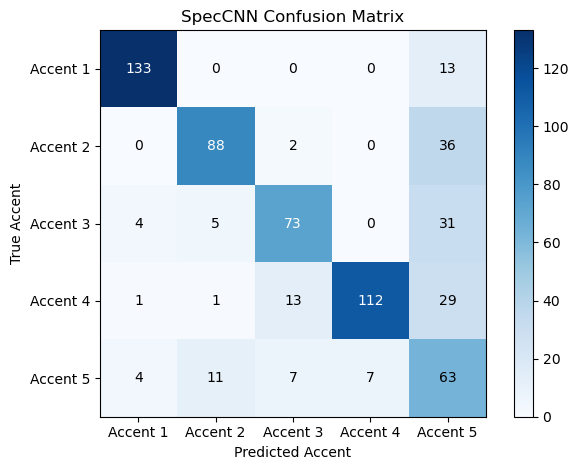

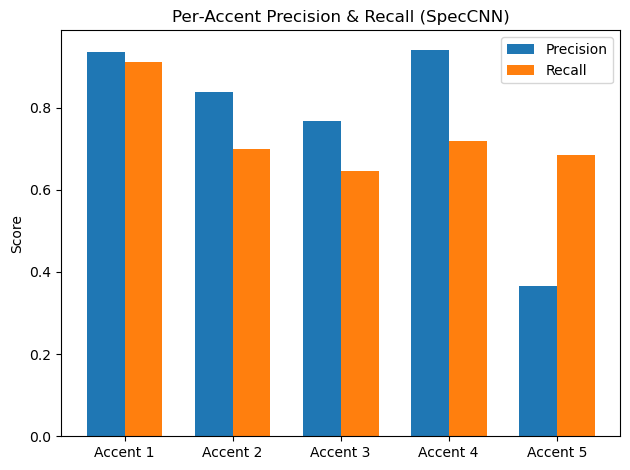

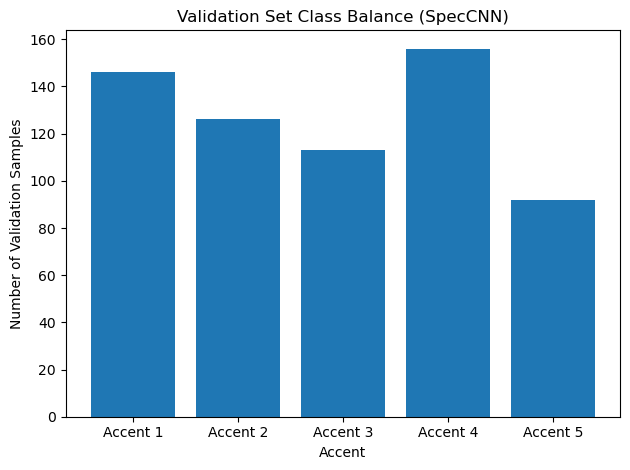

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

def evaluate_and_plot_spec(model, loader, device, class_names=None):
    """
    Runs the spectrogram model on `loader`, prints reports,
    and plots:
      • Confusion‐matrix heatmap
      • Per‐accent precision & recall bar chart
      • Class‐balance bar chart (validation support)
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for specs, accents, genders in loader:
            specs = specs.to(device)
            accents = accents.to(device)
            logits = model(specs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(accents.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    names  = class_names or [f"Accent {i+1}" for i in range(5)]


    print("\nClassification Report (Accents):")
    print(classification_report(
        y_true, y_pred,
        labels=[0,1,2,3,4],
        target_names=names,
        digits=2,
        zero_division=0
    ))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    print("Confusion Matrix:")
    print(cm)


    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(5), yticks=np.arange(5),
        xticklabels=names, yticklabels=names,
        xlabel="Predicted Accent", ylabel="True Accent",
        title="SpecCNN Confusion Matrix"
    )
    thresh = cm.max() / 2
    for i in range(5):
        for j in range(5):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


    prec, rec, _, _ = precision_recall_fscore_support(
        y_true, y_pred,
        labels=[0,1,2,3,4],
        zero_division=0
    )
    x = np.arange(len(names))
    width = 0.35
    fig, ax = plt.subplots()
    ax.bar(x - width/2, prec, width, label="Precision")
    ax.bar(x + width/2, rec,  width, label="Recall")
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylabel("Score")
    ax.set_title("Per‐Accent Precision & Recall (SpecCNN)")
    ax.legend()
    plt.tight_layout()
    plt.show()


    counts = np.bincount(y_true, minlength=5)
    fig, ax = plt.subplots()
    ax.bar(names, counts)
    ax.set_xlabel("Accent")
    ax.set_ylabel("Number of Validation Samples")
    ax.set_title("Validation Set Class Balance (SpecCNN)")
    plt.tight_layout()
    plt.show()


evaluate_and_plot_spec(model_spec, spec_val_loader, device)

--------